# Deep Convolutional GAN (DCGAN)

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from helpers import show_tensor_images
torch.manual_seed(0) # Set for testing purposes, please do not change!


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim ,4* hidden_dim),
            self.make_gen_block(4 * hidden_dim , 2 * hidden_dim , kernel_size = 4 ,stride =1),
            self.make_gen_block(2 * hidden_dim ,hidden_dim),
            self.make_gen_block(hidden_dim , im_chan , final_layer=True , kernel_size=4),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):

        # Build the neural block
        # Use a transposed convolution, Relu, and batchnorm
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels , output_channels , kernel_size , stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(),
                #### END CODE HERE ####
            )
        else: # Final Layer
            # Use a transposed convolution and Tanh as the activation function
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels , output_channels, kernel_size , stride),
                nn.Tanh(),
                #### END CODE HERE ####
            )

    def unsqueeze_noise(self, noise):

        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):

        x = self.unsqueeze_noise(noise)
        #### START CODE HERE ####
        out = self.gen(x)
        #### END CODE HERE ####        
        return out

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    '''
    #### START CODE HERE ####
    noise = torch.randn(n_samples , z_dim,device = device)
    #### END CODE HERE ####
    return noise

## Discriminator
The second component you need to create is the discriminator.

You will use 3 layers in your discriminator's neural network. Like with the generator, you will need create the function to create a single neural network block for the discriminator.
<!-- From the paper, we know that we need to "[u]se LeakyReLU activation in the discriminator for all layers." And for the LeakyReLUs, "the slope of the leak was set to 0.2" in DCGAN. -->



In [4]:
class Discriminator(nn.Module):
    #(im_chan, hidden_dim) --> (hidden_dim, hidden_dim * 2) --> (hidden_dim * 2, 1)
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1 , final_layer = 1),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):

        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.
        #       Note: Don't use an activation on the final layer
        
        # Build the neural block
        # Use a convolution, LeakyReLU with 0.2, and batchnorm
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2),
                
                #### END CODE HERE ####
            )
            # Use a convolution
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                #### END CODE HERE ####
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        #### START CODE HERE #### #
        disc_pred = self.disc(image)
        #### END CODE HERE ####
        return disc_pred.view(len(disc_pred), -1)

In [5]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
'''
Test your make_disc_block() function
'''
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = disc.make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

In [6]:
# Test the hidden block
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
# Because of the LeakyReLU slope
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block

assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Test the whole thing:

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.25
assert disc_output.std() < 0.5
print("Success!")

Success!


## Training
Now you can put it all together!
Remember that these are your parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum term
  *   device: the device type

<!-- In addition, be warned that **this runs very slowly on the default CPU**. One way to run this more quickly is to download the .ipynb and upload it to Google Drive, then open it with Google Colab, click on `Runtime -> Change runtime type` and set hardware accelerator to GPU and replace
`device = "cpu"`
with
`device = "cuda"`. The code should then run without any more changes, over 1,000 times faster.  -->


In [11]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course!
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [12]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  6%|████████████▋                                                                                                                                                                                         | 30/469 [00:00<00:08, 53.03it/s]

Epoch 1, step 500: Generator loss: 0.9225165169835093, discriminator loss: 0.5360256527960299


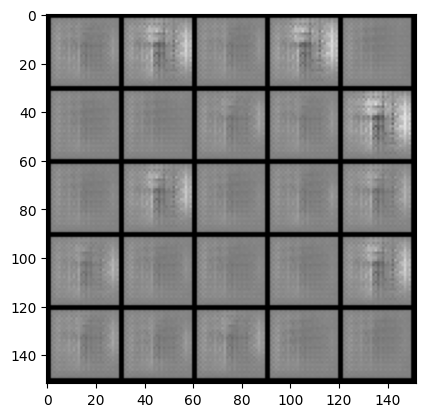

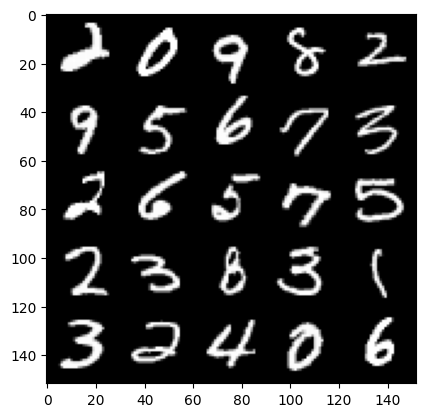

 13%|█████████████████████████▎                                                                                                                                                                            | 60/469 [00:01<00:07, 53.02it/s]

Epoch 2, step 1000: Generator loss: 1.5920190404653543, discriminator loss: 0.3834244424104691


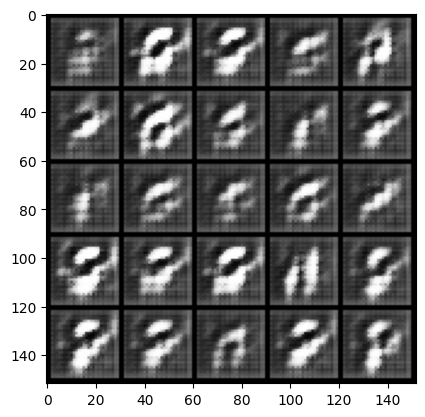

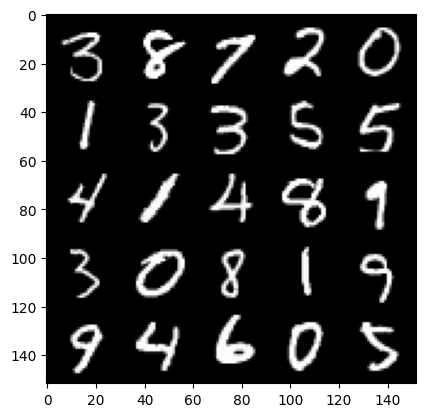

 19%|█████████████████████████████████████▉                                                                                                                                                                | 90/469 [00:01<00:07, 53.52it/s]

Epoch 3, step 1500: Generator loss: 1.1818391574323175, discriminator loss: 0.5099381589889527


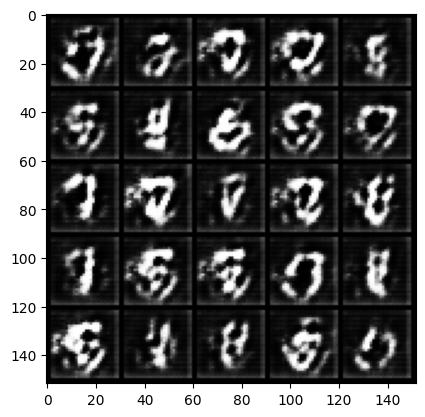

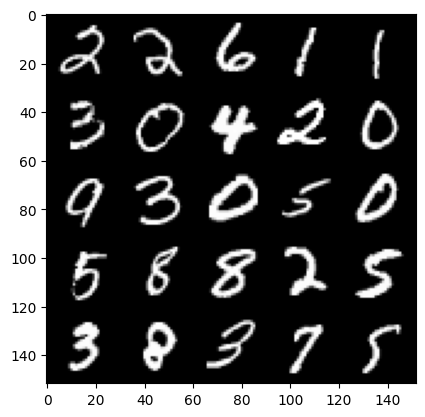

 26%|██████████████████████████████████████████████████▍                                                                                                                                                  | 120/469 [00:02<00:06, 52.06it/s]

Epoch 4, step 2000: Generator loss: 0.92291183000803, discriminator loss: 0.587911030054092


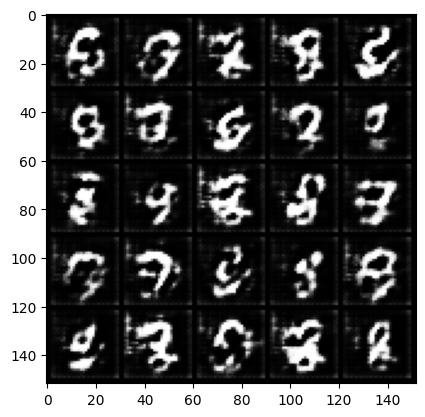

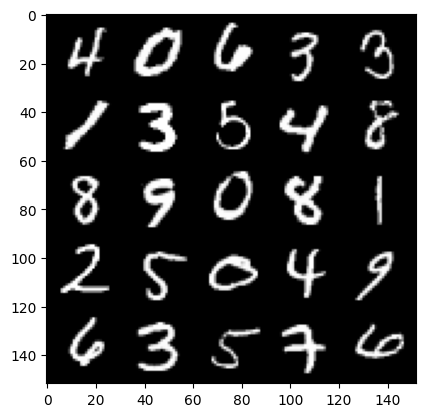

 32%|███████████████████████████████████████████████████████████████                                                                                                                                      | 150/469 [00:02<00:05, 53.36it/s]

Epoch 5, step 2500: Generator loss: 0.8806158452033988, discriminator loss: 0.6116807628870008


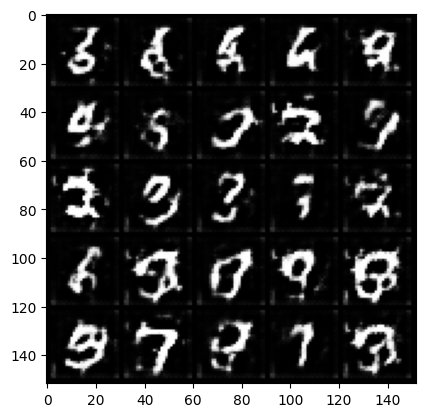

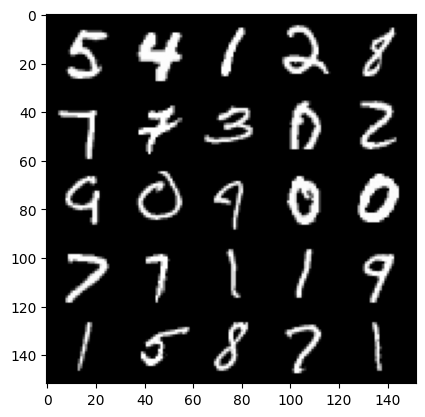

 40%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 186/469 [00:03<00:05, 53.00it/s]

Epoch 6, step 3000: Generator loss: 0.8094026157855985, discriminator loss: 0.6363761826753616


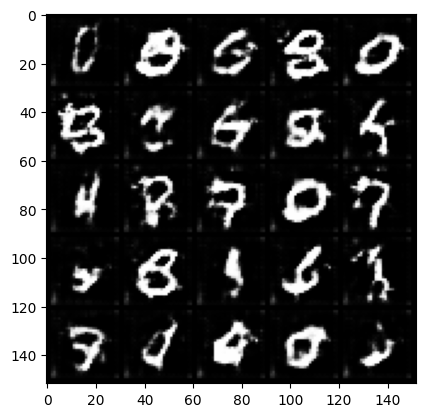

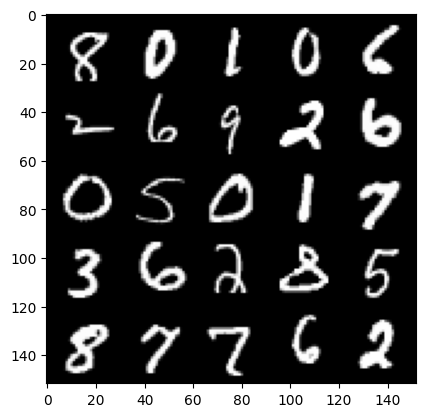

 45%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 212/469 [00:04<00:05, 51.06it/s]

Epoch 7, step 3500: Generator loss: 0.7846767702102654, discriminator loss: 0.6570439736843106


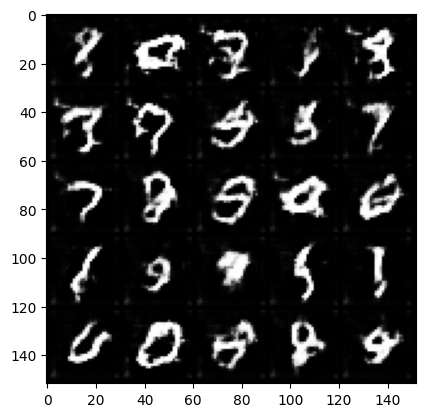

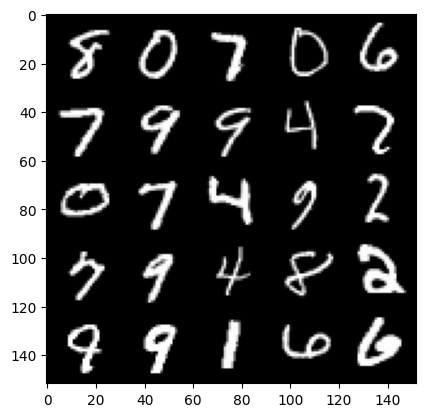

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 245/469 [00:04<00:04, 51.02it/s]

Epoch 8, step 4000: Generator loss: 0.7742871564626697, discriminator loss: 0.6649665601253506


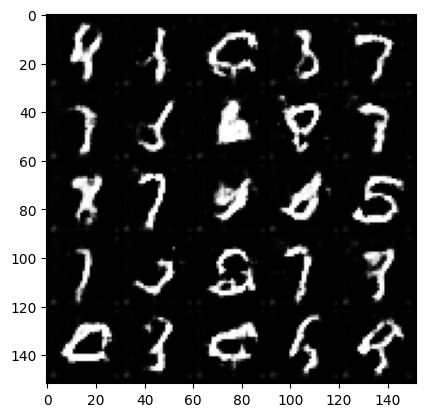

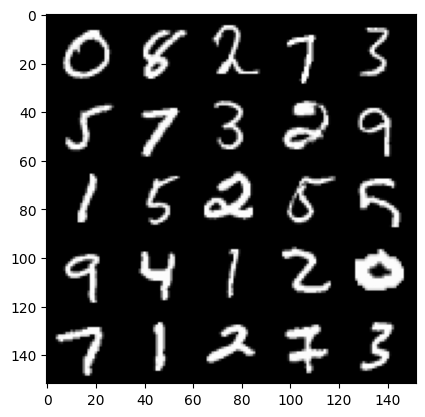

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 277/469 [00:05<00:03, 51.94it/s]

Epoch 9, step 4500: Generator loss: 0.7645387037992475, discriminator loss: 0.6667568134069448


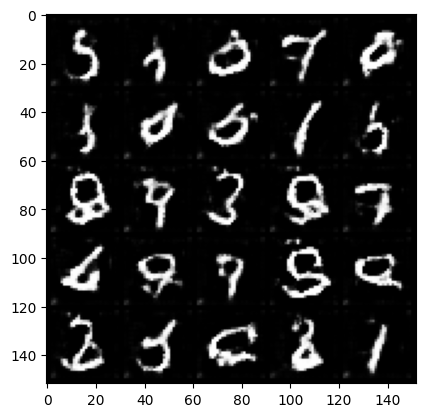

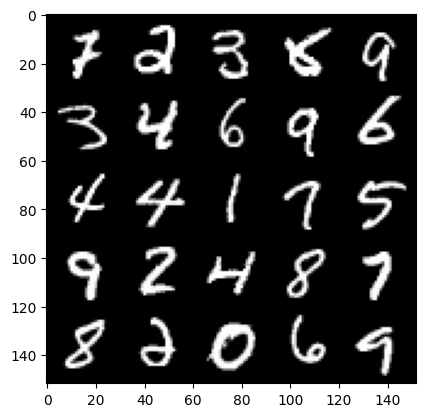

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 305/469 [00:05<00:03, 51.48it/s]

Epoch 10, step 5000: Generator loss: 0.7654516213536254, discriminator loss: 0.668331687569618


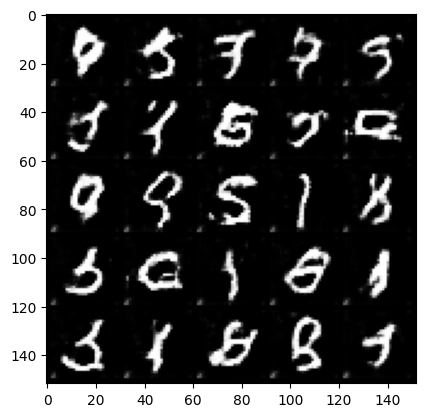

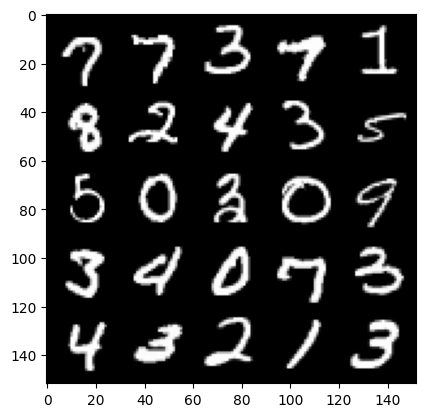

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 341/469 [00:06<00:02, 51.32it/s]

Epoch 11, step 5500: Generator loss: 0.7529508114457119, discriminator loss: 0.6744194235801698


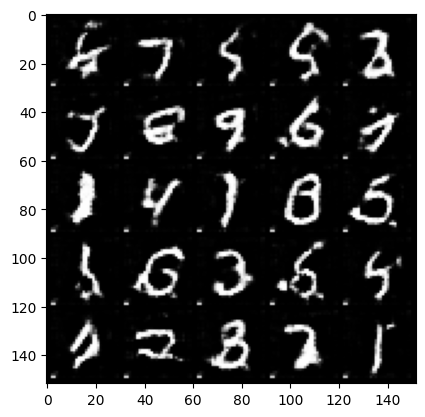

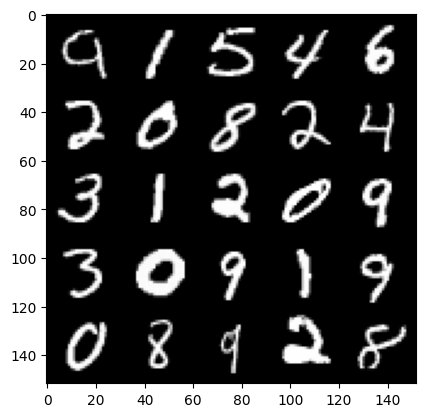

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 369/469 [00:07<00:01, 51.46it/s]

Epoch 12, step 6000: Generator loss: 0.7556352589130405, discriminator loss: 0.675231233119965


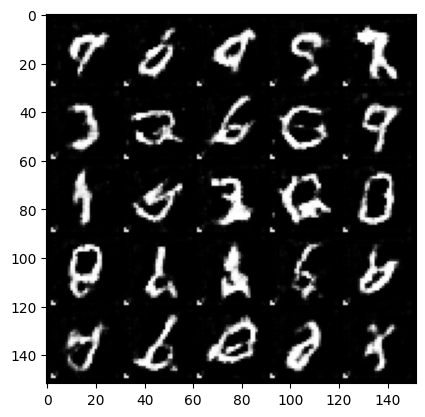

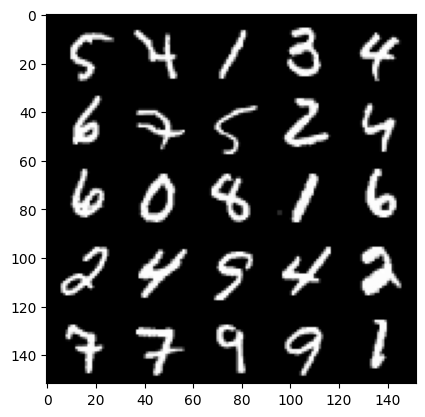

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 401/469 [00:07<00:01, 52.53it/s]

Epoch 13, step 6500: Generator loss: 0.7538130006790156, discriminator loss: 0.672958570718766


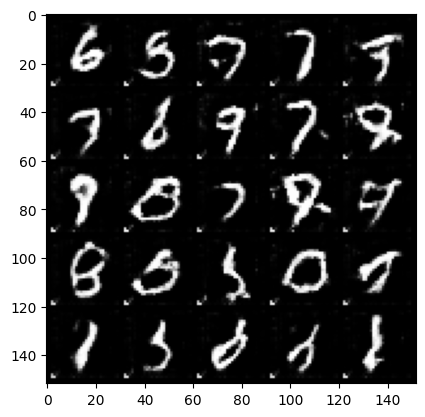

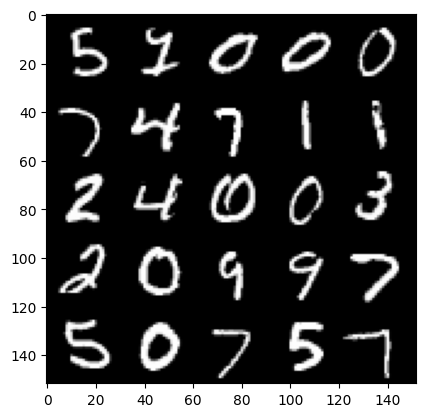

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 432/469 [00:08<00:00, 52.46it/s]

Epoch 14, step 7000: Generator loss: 0.7520200152397156, discriminator loss: 0.6732809970378879


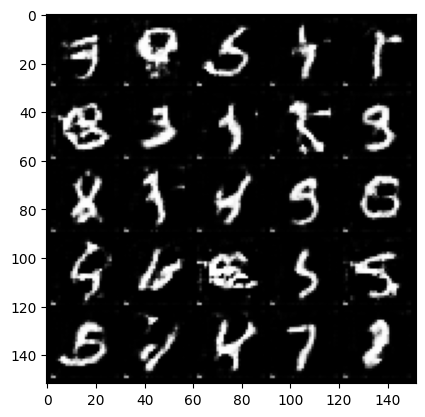

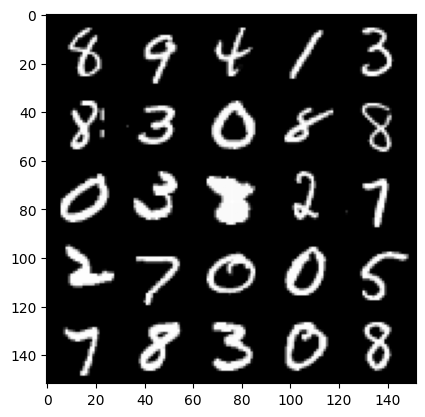

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 460/469 [00:08<00:00, 51.15it/s]

Epoch 15, step 7500: Generator loss: 0.7519086154103278, discriminator loss: 0.6742914113998418


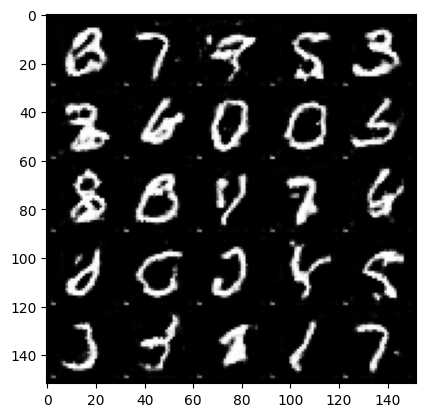

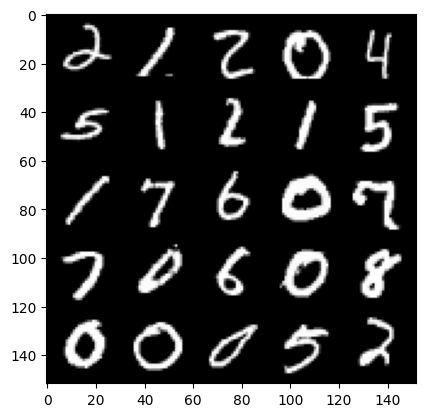

  5%|█████████▋                                                                                                                                                                                            | 23/469 [00:00<00:08, 50.89it/s]

Epoch 17, step 8000: Generator loss: 0.7478645627498628, discriminator loss: 0.6747412508726122


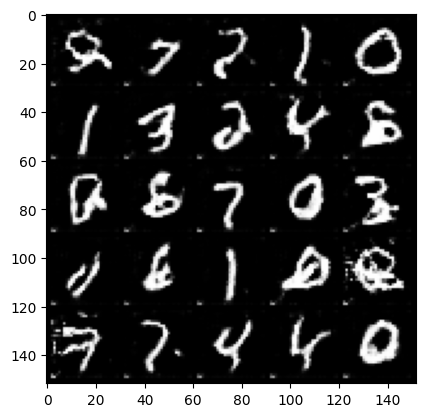

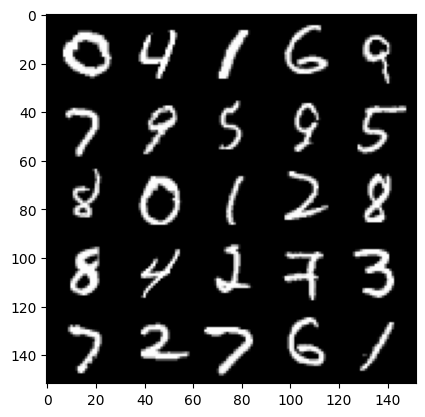

 12%|██████████████████████▊                                                                                                                                                                               | 54/469 [00:01<00:08, 51.45it/s]

Epoch 18, step 8500: Generator loss: 0.7494511635899549, discriminator loss: 0.6781331888437271


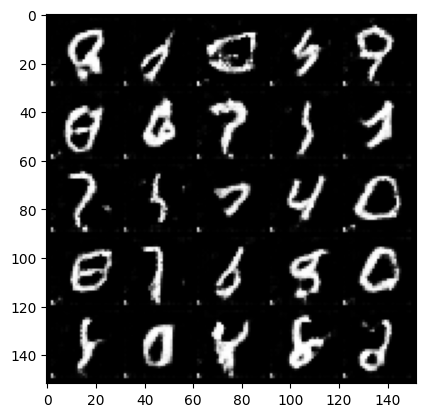

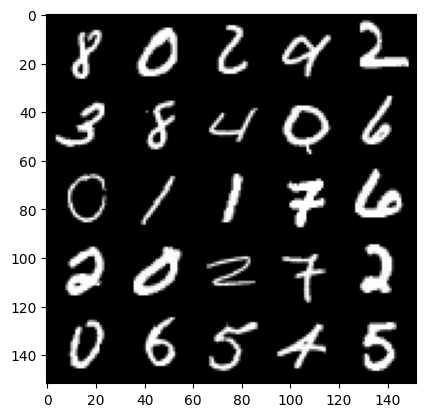

 19%|█████████████████████████████████████▏                                                                                                                                                                | 88/469 [00:01<00:07, 49.10it/s]

Epoch 19, step 9000: Generator loss: 0.7444676840305336, discriminator loss: 0.6776967070102692


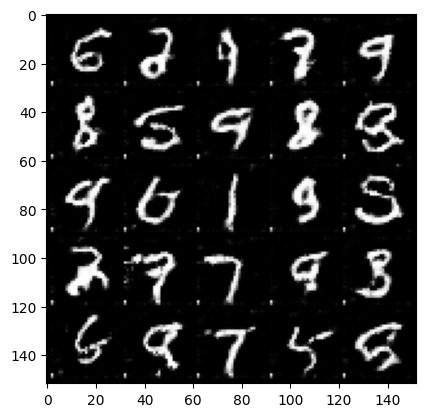

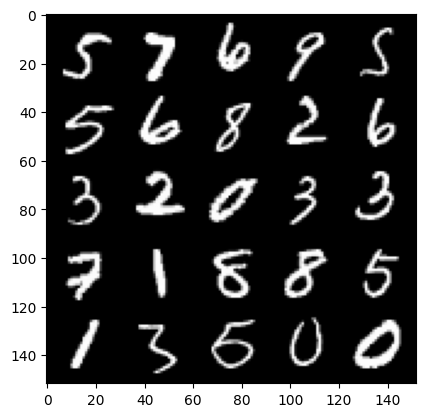

 25%|█████████████████████████████████████████████████▉                                                                                                                                                   | 119/469 [00:02<00:06, 50.85it/s]

Epoch 20, step 9500: Generator loss: 0.7407381020188332, discriminator loss: 0.6789397597312928


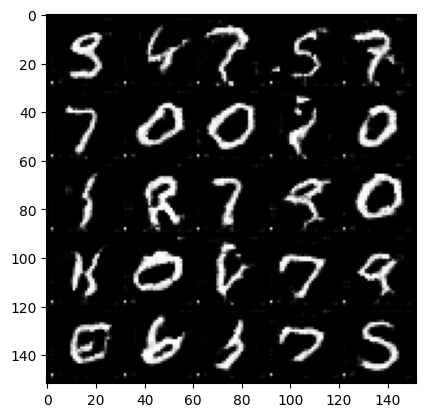

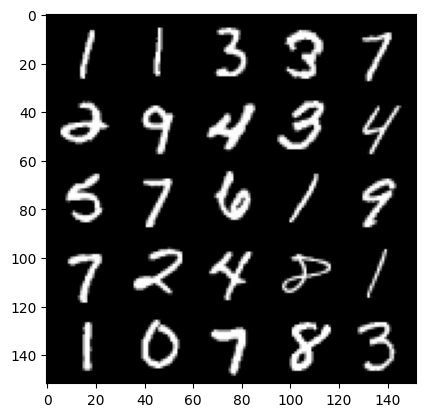

 32%|███████████████████████████████████████████████████████████████                                                                                                                                      | 150/469 [00:02<00:06, 53.16it/s]

Epoch 21, step 10000: Generator loss: 0.7386064429283145, discriminator loss: 0.6810968273878099


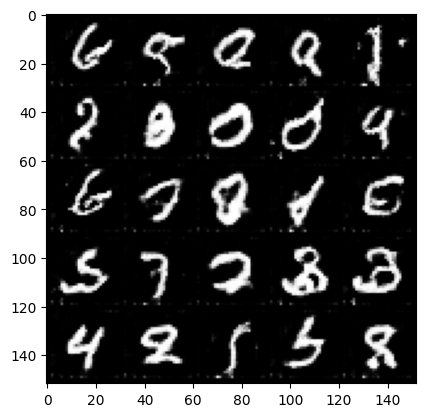

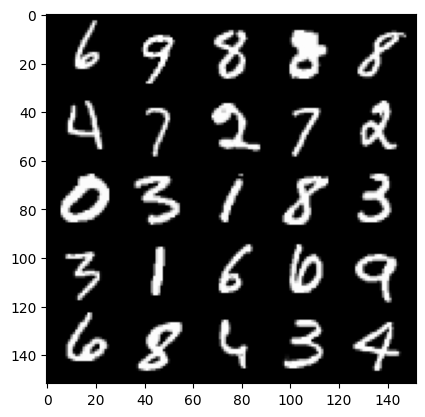

 38%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 180/469 [00:03<00:05, 52.69it/s]

Epoch 22, step 10500: Generator loss: 0.7381491268873209, discriminator loss: 0.681194581866265


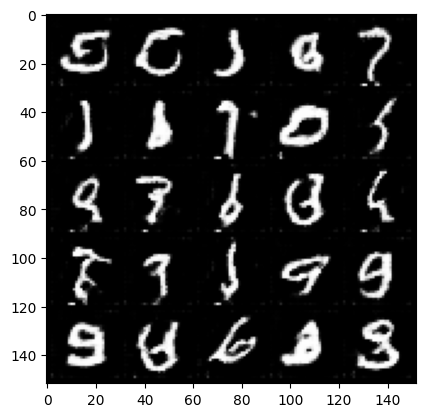

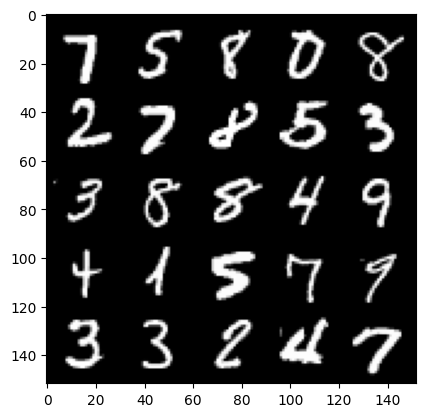

 44%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 208/469 [00:04<00:04, 52.58it/s]

Epoch 23, step 11000: Generator loss: 0.7357921106219297, discriminator loss: 0.6840501707792283


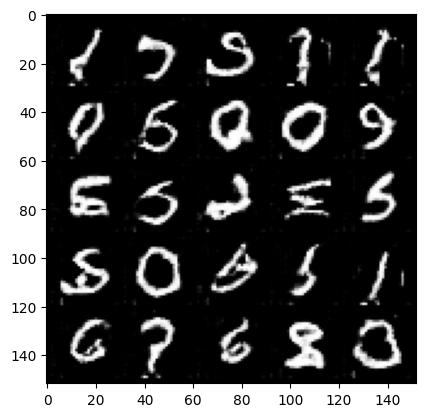

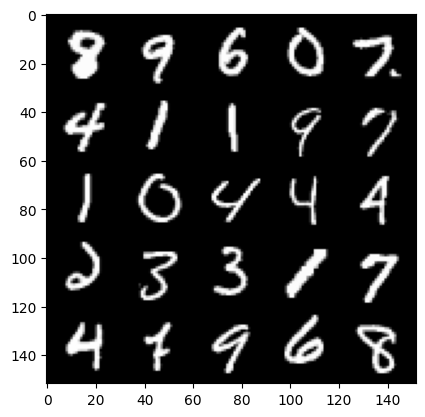

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 239/469 [00:04<00:04, 51.99it/s]

Epoch 24, step 11500: Generator loss: 0.7353665922284122, discriminator loss: 0.683793336033821


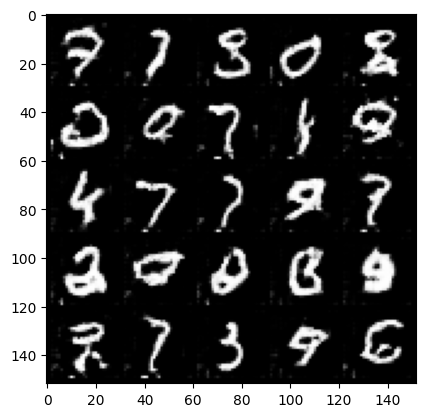

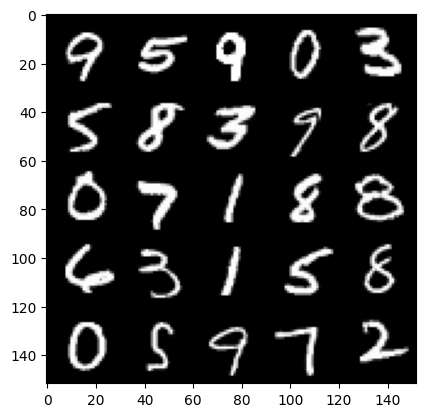

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 272/469 [00:05<00:03, 49.60it/s]

Epoch 25, step 12000: Generator loss: 0.7311382122039798, discriminator loss: 0.6834746277332305


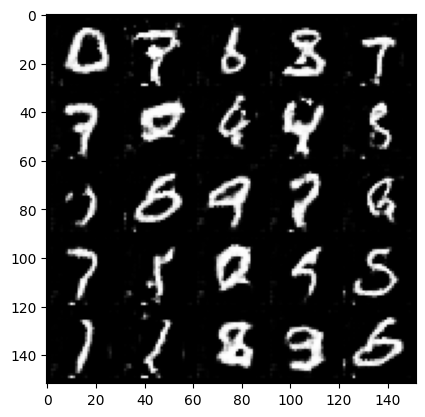

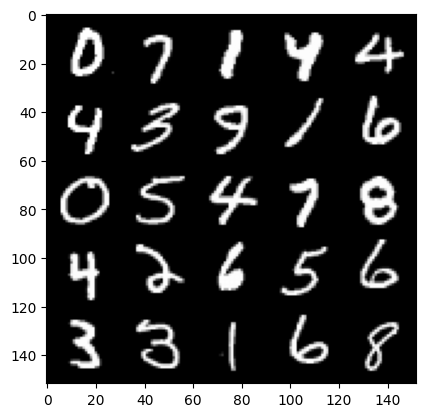

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 301/469 [00:05<00:03, 51.33it/s]

Epoch 26, step 12500: Generator loss: 0.7310764458179481, discriminator loss: 0.6858828538656231


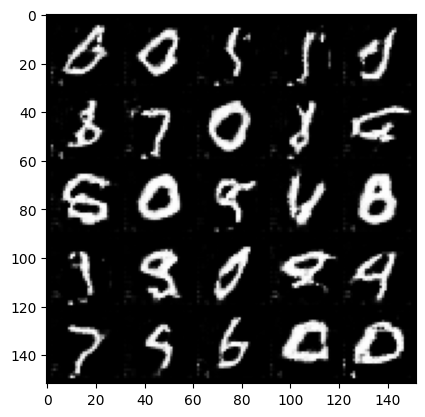

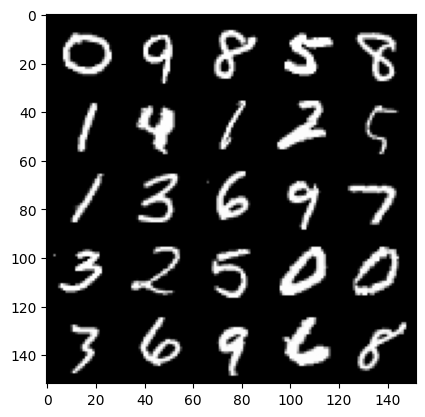

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 337/469 [00:06<00:02, 52.27it/s]

Epoch 27, step 13000: Generator loss: 0.7299141945242886, discriminator loss: 0.6857709941864015


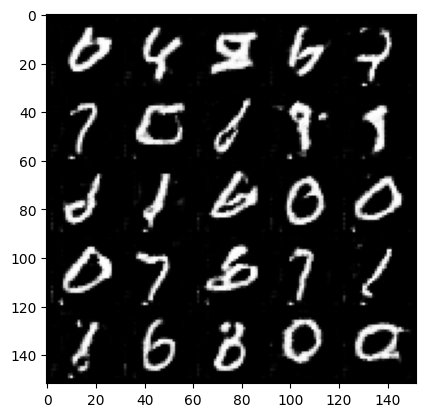

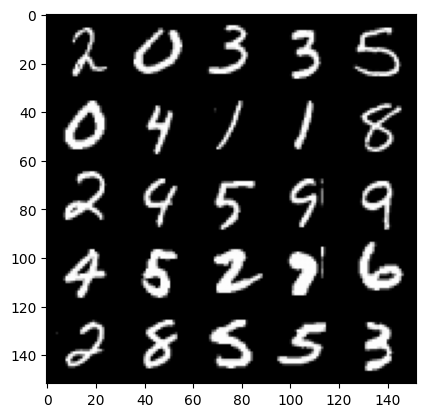

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 364/469 [00:07<00:02, 50.30it/s]

Epoch 28, step 13500: Generator loss: 0.7300100369453432, discriminator loss: 0.6868324569463728


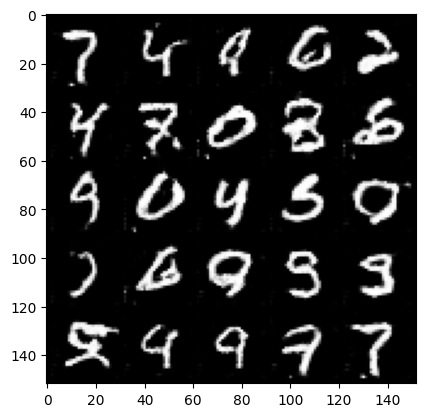

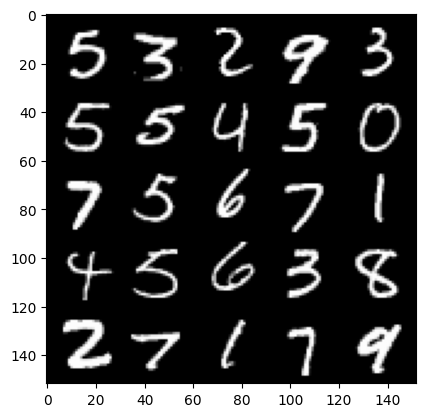

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 394/469 [00:07<00:01, 52.26it/s]

Epoch 29, step 14000: Generator loss: 0.7248344961404801, discriminator loss: 0.6888703057765961


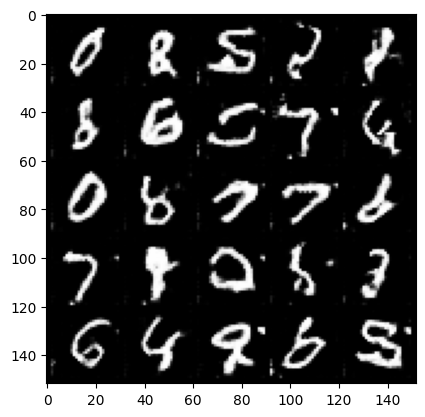

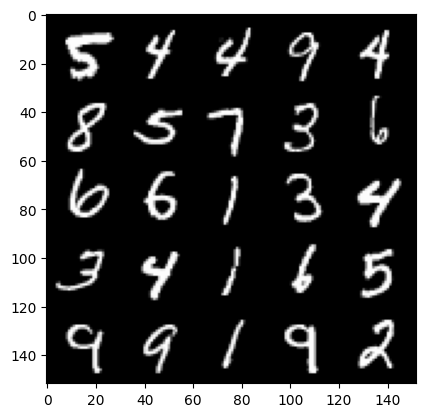

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 425/469 [00:08<00:00, 49.71it/s]

Epoch 30, step 14500: Generator loss: 0.7225461643934251, discriminator loss: 0.6904127835035331


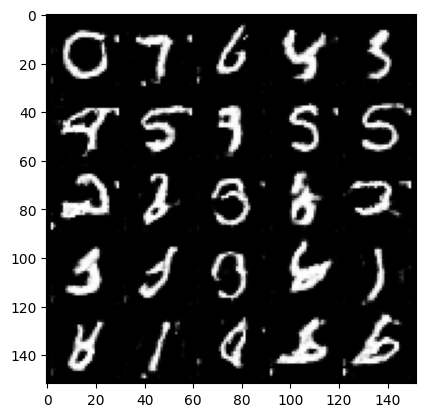

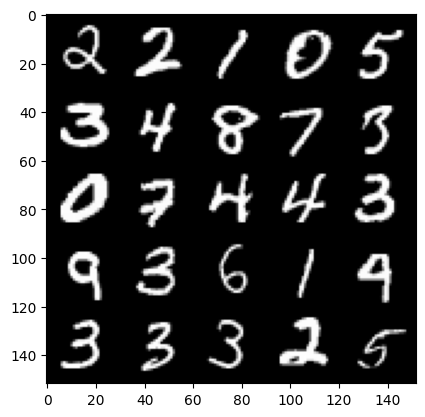

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 458/469 [00:09<00:00, 50.30it/s]

Epoch 31, step 15000: Generator loss: 0.7227040319442752, discriminator loss: 0.6900954620838161


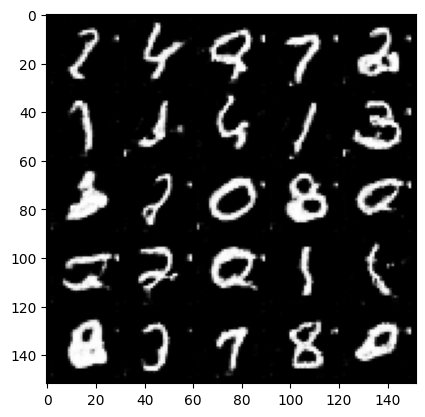

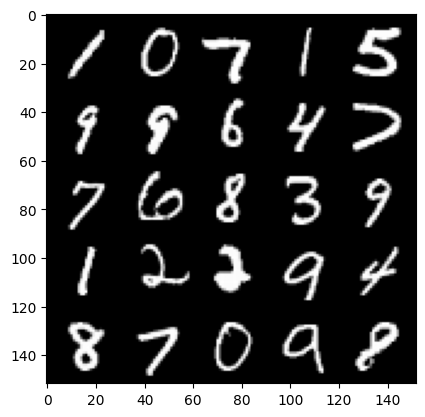

  5%|█████████▎                                                                                                                                                                                            | 22/469 [00:00<00:08, 51.47it/s]

Epoch 33, step 15500: Generator loss: 0.7175800631046291, discriminator loss: 0.6900826877355575


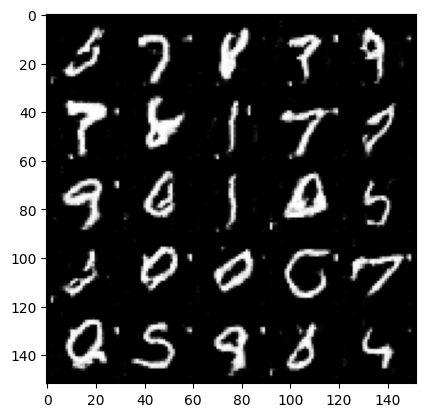

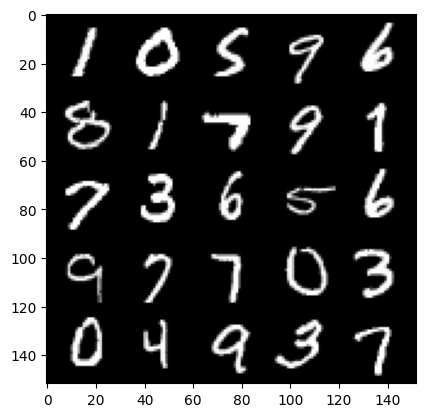

 11%|██████████████████████▍                                                                                                                                                                               | 53/469 [00:01<00:07, 52.91it/s]

Epoch 34, step 16000: Generator loss: 0.7178786628246305, discriminator loss: 0.6905590753555293


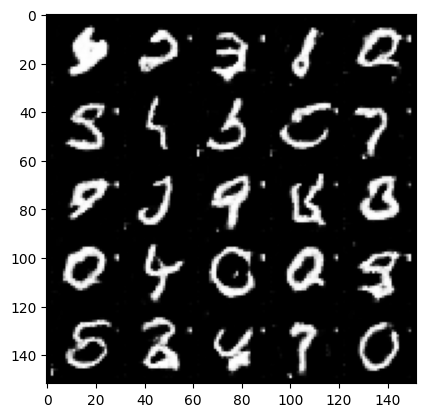

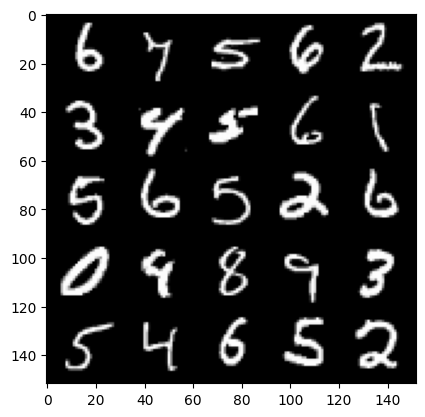

 18%|███████████████████████████████████                                                                                                                                                                   | 83/469 [00:01<00:08, 48.06it/s]

Epoch 35, step 16500: Generator loss: 0.7166448122262962, discriminator loss: 0.69135872900486


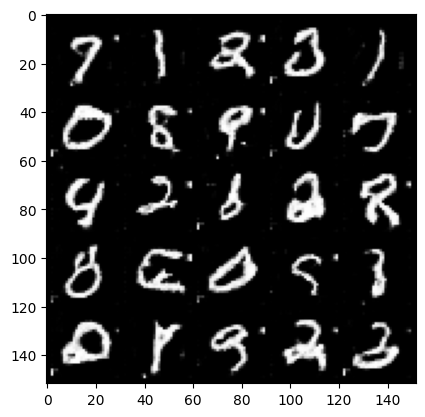

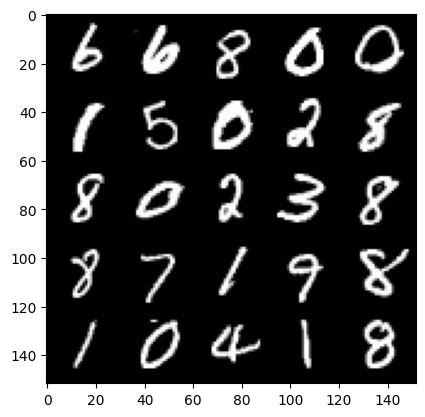

 24%|███████████████████████████████████████████████▉                                                                                                                                                     | 114/469 [00:02<00:07, 50.06it/s]

Epoch 36, step 17000: Generator loss: 0.7171560526490213, discriminator loss: 0.6919307101964948


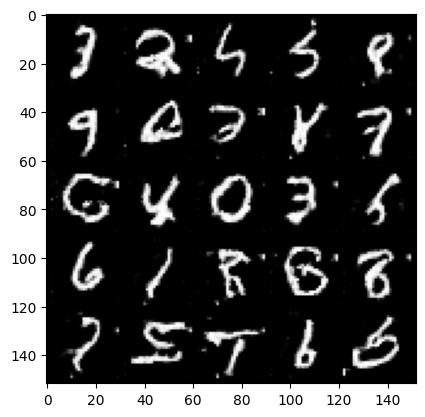

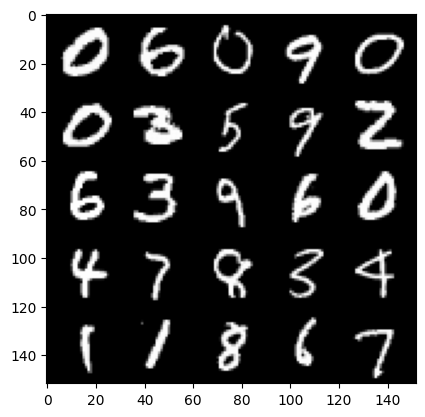

 30%|████████████████████████████████████████████████████████████                                                                                                                                         | 143/469 [00:02<00:06, 51.76it/s]

Epoch 37, step 17500: Generator loss: 0.713234881699086, discriminator loss: 0.6920143343210224


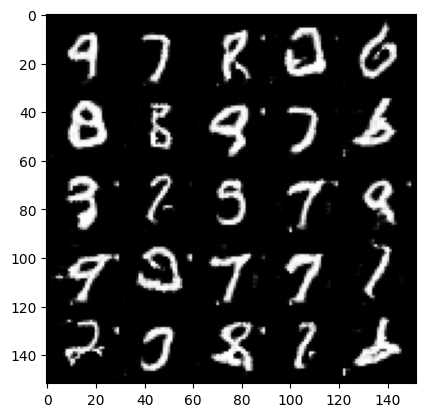

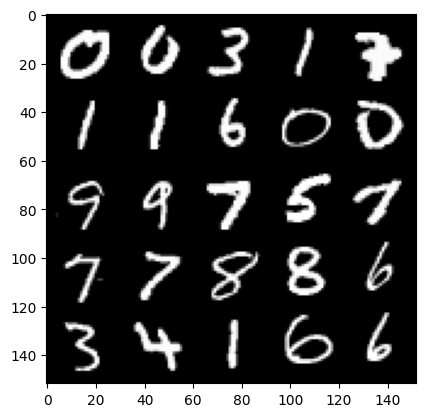

 37%|████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 173/469 [00:03<00:05, 52.48it/s]

Epoch 38, step 18000: Generator loss: 0.7125803494453432, discriminator loss: 0.6931939167976373


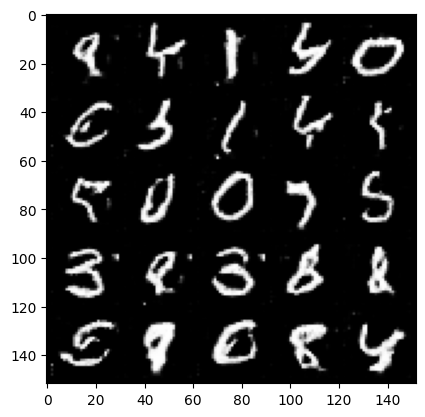

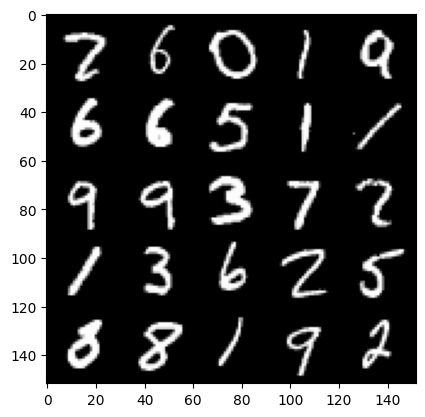

 43%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 204/469 [00:03<00:05, 52.89it/s]

Epoch 39, step 18500: Generator loss: 0.7137456723451611, discriminator loss: 0.6931201511621472


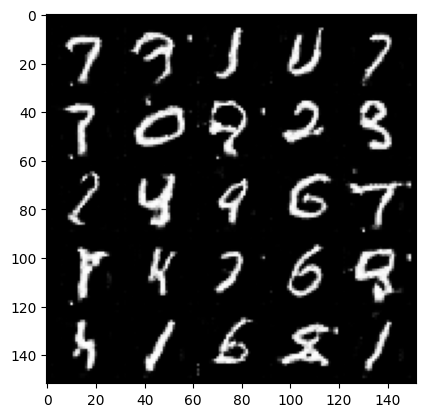

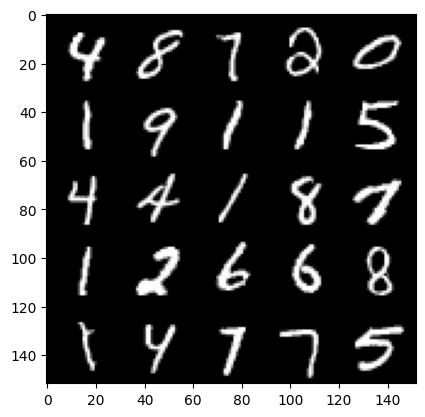

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 240/469 [00:04<00:04, 50.58it/s]

Epoch 40, step 19000: Generator loss: 0.7087852023243901, discriminator loss: 0.6941287291049965


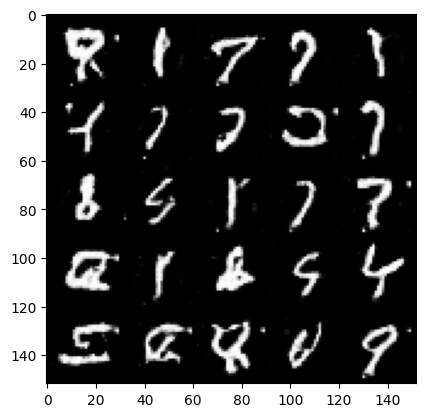

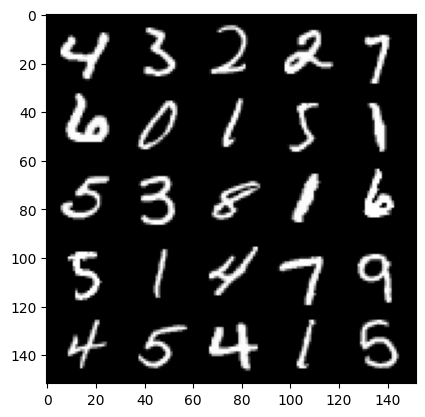

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 268/469 [00:05<00:03, 53.31it/s]

Epoch 41, step 19500: Generator loss: 0.7083329422473911, discriminator loss: 0.6954326417446138


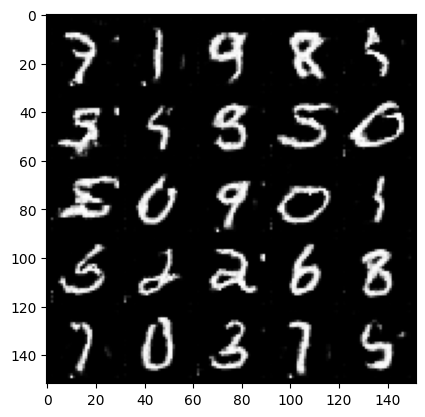

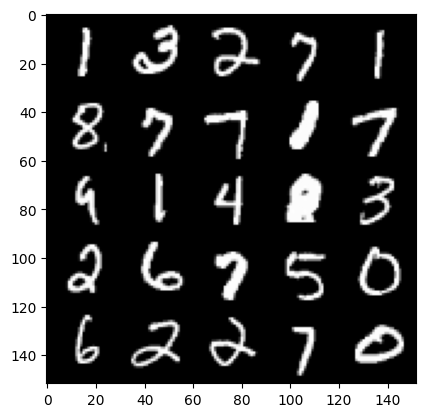

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 300/469 [00:05<00:03, 52.68it/s]

Epoch 42, step 20000: Generator loss: 0.7060143857002261, discriminator loss: 0.694762651443481


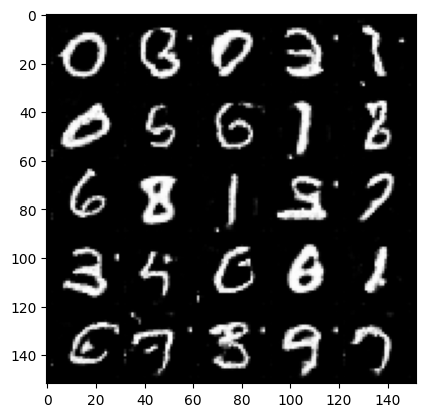

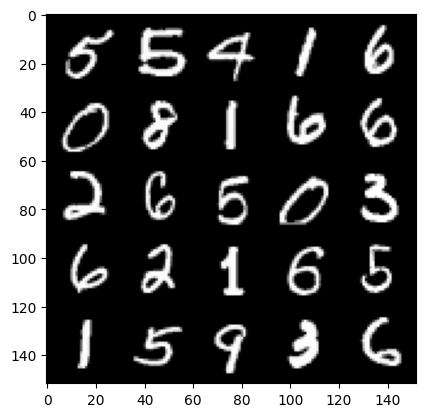

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 330/469 [00:06<00:02, 52.60it/s]

Epoch 43, step 20500: Generator loss: 0.7096611071228981, discriminator loss: 0.6946932992935183


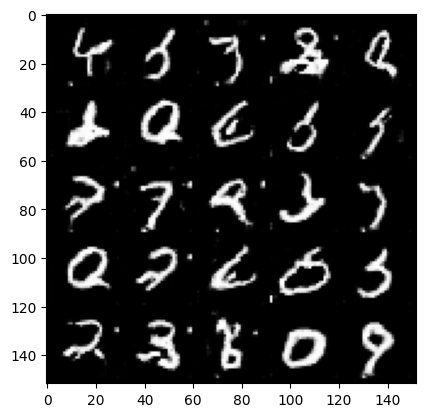

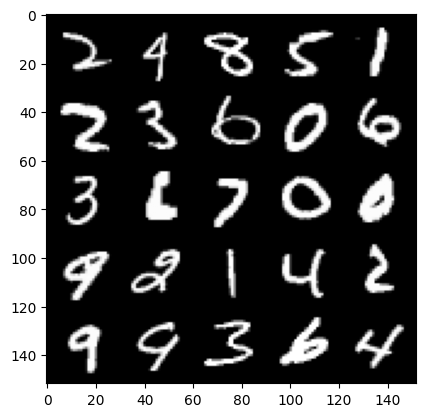

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 360/469 [00:06<00:02, 52.99it/s]

Epoch 44, step 21000: Generator loss: 0.7070283808112146, discriminator loss: 0.6947881677150728


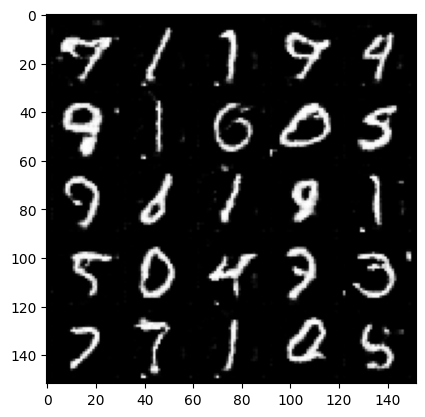

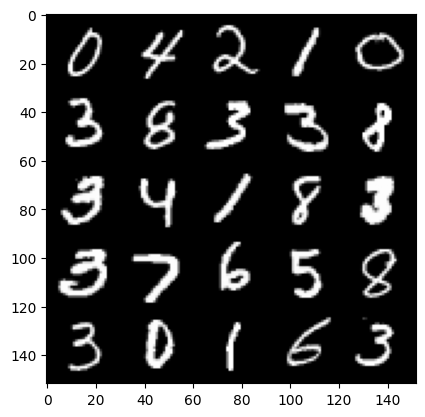

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 394/469 [00:07<00:01, 51.57it/s]

Epoch 45, step 21500: Generator loss: 0.7054636846780772, discriminator loss: 0.6949614148139958


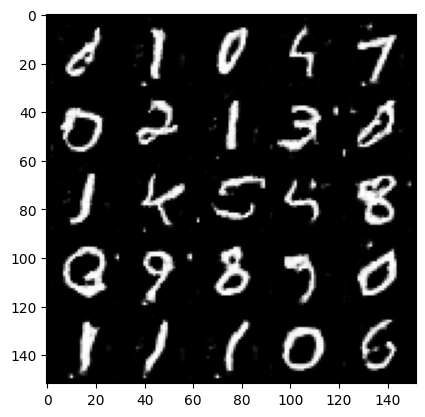

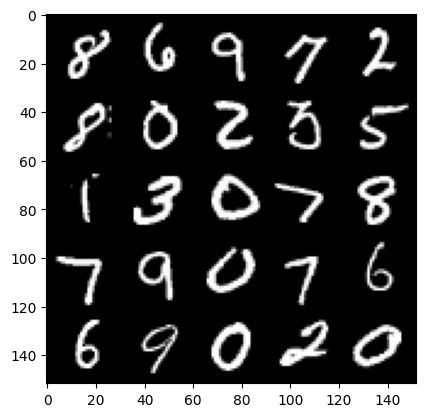

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 426/469 [00:08<00:00, 50.28it/s]

Epoch 46, step 22000: Generator loss: 0.7047046924233439, discriminator loss: 0.6949967993497848


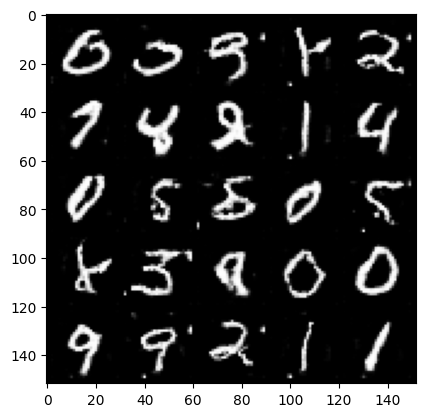

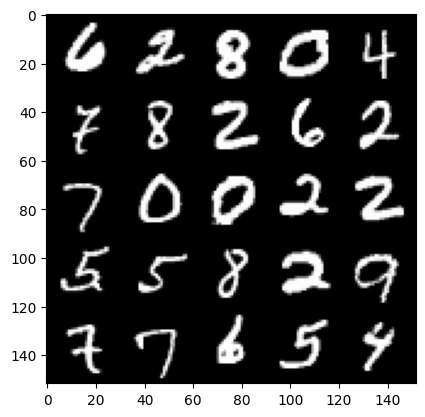

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 454/469 [00:08<00:00, 51.44it/s]

Epoch 47, step 22500: Generator loss: 0.7063386065959931, discriminator loss: 0.6954365856647492


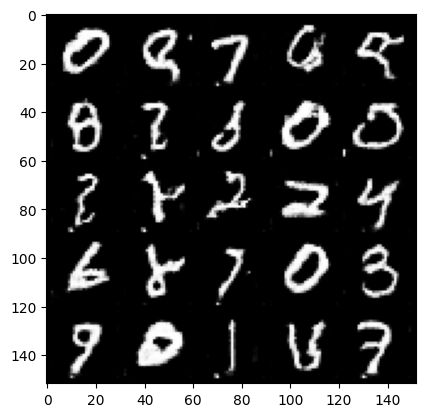

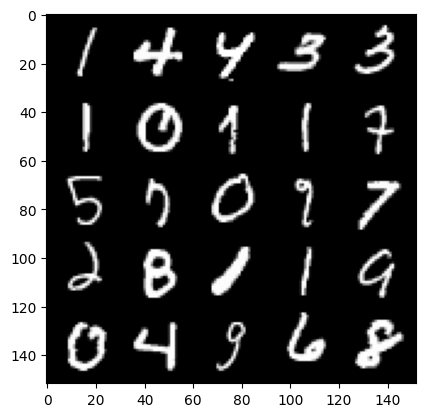

  4%|███████▏                                                                                                                                                                                              | 17/469 [00:00<00:08, 52.23it/s]

Epoch 49, step 23000: Generator loss: 0.7039665898084642, discriminator loss: 0.6953786993026728


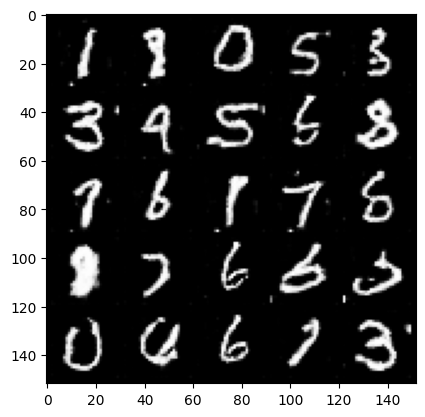

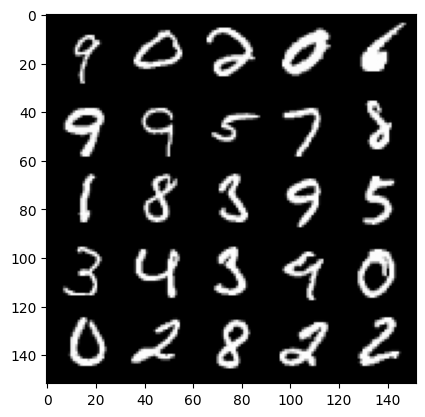

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:09<00:00, 51.46it/s]


In [15]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred ))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update Discriminator gradients
        disc_loss.backward()
        # Update Discriminator optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
       # Update Generator gradients
        gen_loss.backward()
        # Update Generator optimizer
        gen_opt.step()
        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

